# Работа с автокодировщиками

по материалам kaggle [MNIST](https://www.kaggle.com/datasets/avnishnish/mnist-original)

# Подготовка

## Загрузка библиотек

In [ ]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras import regularizers
from keras.callbacks import EarlyStopping
from scipy.io import loadmat
import json
import numpy as np
import time

In [ ]:
def plot_loss(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_image(image):
    plt.imshow(image.reshape((28, 28)))
    return

def plot_images_sample(images):
    plt.figure(figsize=(8, 5))
    plt.subplots_adjust(wspace=0, hspace=0)
    random_indices = random.sample(range(len(images)), 40)
    for i in range(40):
        plt.gray()
        subplot = plt.subplot(5, 8, i + 1)
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)

        plot_image(images[random_indices[i]])

def plot_comparison(input_images, output_images):
    plt.figure(figsize=(18, 4))
    plt.subplots_adjust(wspace=0, hspace=0)
    random_indices = random.sample(range(len(input_images)), 12)
    for i in range(12):
        plt.gray()
        subplot = plt.subplot(2, 12, i + 1)
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        plot_image(input_images[random_indices[i]])
        subplot = plt.subplot(2, 12, i + 1 + 12)
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        plot_image(output_images[random_indices[i]])

def save_to_file(var, filename):
    js = json.dumps(var)
    f = open(filename, "w")
    f.write(js)
    f.close()

def load_from_file(filename):
    f = open(filename, "r")
    js = f.read()
    return json.loads(js)

## Настройка сети

In [ ]:
training_epochs = 100
train_to_test_ratio = 0.85
input_size = 28 * 28
encoded_size = 7 * 7
activation = 'elu'
optimizer = 'adadelta'
loss = 'binary_crossentropy'
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]
use_serialized = False

## Тренировка и тестирование

In [ ]:
# Импорт данных с kaggle

!pip install kaggle # переустановка kaggle библиотеки

In [ ]:
!mkdir -p ~/.kaggle/ # создать .kaggle папку на диске

In [ ]:
!gdown --id 1t-mnytI2dPwnSiMico5PqSJFskhX5r_g # загрузка файла с диска

# https://drive.google.com/file/d/1t-mnytI2dPwnSiMico5PqSJFskhX5r_g/view?usp=sharing


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1t-mnytI2dPwnSiMico5PqSJFskhX5r_g
To: /content/kaggle.json
100% 63.0/63.0 [00:00<00:00, 203kB/s]


In [ ]:
!cp /content/kaggle.json ~/.kaggle

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d avnishnish/mnist-original #обычные датасеты

 46% 5.00M/10.9M [00:00<00:00, 43.4MB/s]
100% 10.9M/10.9M [00:00<00:00, 73.8MB/s]


In [ ]:
!ls # список временных файлов в content

kaggle.json  mnist-original.zip  sample_data


In [ ]:
!unzip mnist-original.zip

Archive:  mnist-original.zip
  inflating: mnist-original.mat      


In [ ]:
# load the dataset
mnist = loadmat("mnist-original.mat")

# get the image data from the dataset
images = mnist["data"].T

# convert image data into float format
images = images / 255

# split into training and test images
train_count = round(len(images) * train_to_test_ratio)
test_count = len(images) - train_count
train_images = images[:train_count]
test_images = images[-test_count:]

print("все изображения:", images.shape)
print("тренировочная выборка:", train_images.shape)
print("тестовая выборка:", test_images.shape)

все изображения: (70000, 784)
тренировочная выборка: (59500, 784)
тестовая выборка: (10500, 784)


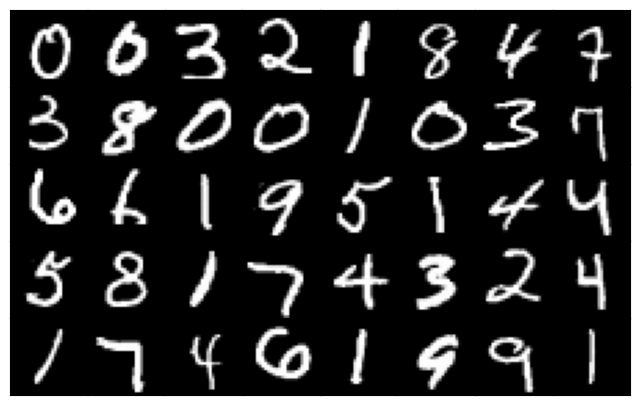

In [ ]:
plot_images_sample(train_images)

# Vanilla Autoencoder

## Архитектура

![](https://i.imgur.com/6x2It1E.png)

In [ ]:
# if (use_serialized):
#     vanilla_autoencoder = load_model('vanilla.h5')
#     vanilla_encoder = load_model('vanilla_encoder.h5')
#     vanilla_decoder = load_model('vanilla_decoder.h5')

# else:
input_layer = Input(shape=(input_size,))

# кодировщик
encoded_layer = Dense(encoded_size, activation=activation)(input_layer)

# декодер
decoded_layer = Dense(input_size, activation='sigmoid')(encoded_layer)

# автоэнкодер
vanilla_autoencoder = Model(input_layer, decoded_layer)
vanilla_autoencoder._name = "model_autoencoder"

# разделенные модели кодировщика и декодера
vanilla_encoder = Model(input_layer, encoded_layer)
vanilla_encoder._name = "model_encoded"

encoded_input_layer = Input(shape=(encoded_size,))
vanilla_decoder = Model(encoded_input_layer, vanilla_autoencoder.layers[-1](encoded_input_layer))
vanilla_decoder._name = "model_decoded"

# распечатать показатели моделей
vanilla_autoencoder.summary()
vanilla_encoder.summary()
vanilla_decoder.summary()

Model: "model_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 49)                38465     
                                                                 
 dense_5 (Dense)             (None, 784)               39200     
                                                                 
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________
Model: "model_encoded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)      

## Тренировка модели

Train on 59500 samples, validate on 10500 samples
Epoch 1/100
59500/59500 [==============================] - 2s 33us/step - loss: 0.3472 - val_loss: 0.2665
Epoch 2/100
59500/59500 [==============================] - 1s 17us/step - loss: 0.2584 - val_loss: 0.2439
Epoch 3/100
59500/59500 [==============================] - 1s 17us/step - loss: 0.2346 - val_loss: 0.2206
Epoch 4/100
59500/59500 [==============================] - 1s 17us/step - loss: 0.2150 - val_loss: 0.2044
Epoch 5/100
59500/59500 [==============================] - 1s 17us/step - loss: 0.2011 - val_loss: 0.1925
Epoch 6/100
59500/59500 [==============================] - 1s 16us/step - loss: 0.1901 - val_loss: 0.1826
Epoch 7/100
59500/59500 [==============================] - 1s 17us/step - loss: 0.1810 - val_loss: 0.1744
Epoch 8/100
59500/59500 [==============================] - 1s 16us/step - loss: 0.1734 - val_loss: 0.1678
Epoch 9/100
59500/59500 [==============================] - 1s 17us/step - loss: 0.1672 - val_loss: 0.1

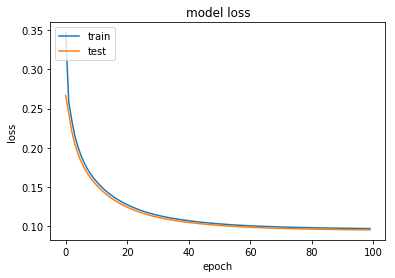

loss: 0.09706541916152009
val_loss: 0.09534226508651461


In [ ]:
if (use_serialized):
    history = load_from_file('vanilla_history.json')

else:
    vanilla_autoencoder.compile(optimizer=optimizer, loss=loss)
    start = time.time()
    history = vanilla_autoencoder.fit(train_images, train_images,
                            epochs=training_epochs,
                            batch_size=256,
                            shuffle=True,
                            validation_data=(test_images, test_images),
                            callbacks=callbacks).history
    print('training time:', time.time() - start)
    save_to_file(history, 'vanilla_history.json')
    vanilla_autoencoder.save('vanilla.h5')
    vanilla_encoder.save('vanilla_encoder.h5')
    vanilla_decoder.save('vanilla_decoder.h5')

plot_loss(history)
print("loss:", history["loss"][-1])
print("val_loss:", history["val_loss"][-1])


## Testing

In [ ]:
# кодирование изображений
encoded_images = vanilla_encoder.predict(test_images)
print("кодирование изображений:", encoded_images.shape)

#декодирование изображений
decoded_images = vanilla_decoder.predict(encoded_images)
print("декодирование изображений:", decoded_images.shape)

329/329 [==============================] - 1s 2ms/step
кодирование изображений: (10500, 49)
329/329 [==============================] - 0s 1ms/step
декодирование изображений: (10500, 784)


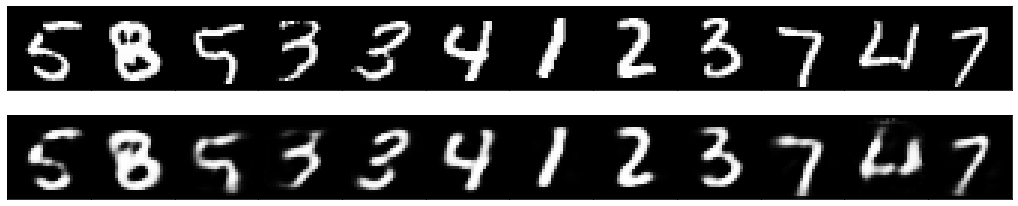

In [ ]:
plot_comparison(test_images, decoded_images)

# Многослойный автоэнкодер

## Архитектура

![](https://i.imgur.com/2qyAqwO.png)

In [ ]:
if (use_serialized):
    multilayer_autoencoder = load_model('multilayer.h5')
    multilayer_encoder = load_model('multilayer_encoder.h5')
    multilayer_decoder = load_model('multilayer_decoder.h5')

else:
    input_layer = Input(shape=(input_size,))

    # кодировщик
    hidden_encoder_layer = Dense(round((input_size + encoded_size) / 4), activation=activation)(input_layer)
    encoded_layer = Dense(encoded_size, activation=activation)(hidden_encoder_layer)

    # декодер
    hidden_decoder_layer = Dense(round((input_size + encoded_size) / 4), activation=activation)(encoded_layer)
    decoded_layer = Dense(input_size, activation='sigmoid')(hidden_decoder_layer)

    # автокодировщик
    multilayer_autoencoder = Model(input_layer, decoded_layer)
    multilayer_autoencoder._name = "multilayer_autoencoder"

    # раздельные показатели кодировщика и декодера
    multilayer_encoder = Model(input_layer, encoded_layer)
    multilayer_encoder._name = "multilayer_encoder"

    encoded_input_layer = Input(shape=(encoded_size,))
    multilayer_decoder = Model(encoded_input_layer, multilayer_autoencoder.layers[-1](multilayer_autoencoder.layers[-2](encoded_input_layer)))
    multilayer_decoder._name = "multilayer_decoder"

# распечатать показатели моделей
multilayer_autoencoder.summary()
multilayer_decoder.summary()
multilayer_encoder.summary()


Model: "multilayer_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 208)               163280    
                                                                 
 dense_3 (Dense)             (None, 49)                10241     
                                                                 
 dense_4 (Dense)             (None, 208)               10400     
                                                                 
 dense_5 (Dense)             (None, 784)               163856    
                                                                 
Total params: 347,777
Trainable params: 347,777
Non-trainable params: 0
_________________________________________________________________
Model: "multilayer_decoder"
__________

Train on 59500 samples, validate on 10500 samples
Epoch 1/100
59500/59500 [==============================] - 1s 24us/step - loss: 0.3032 - val_loss: 0.2482
Epoch 2/100
59500/59500 [==============================] - 1s 21us/step - loss: 0.2296 - val_loss: 0.2055
Epoch 3/100
59500/59500 [==============================] - 1s 21us/step - loss: 0.1937 - val_loss: 0.1804
Epoch 4/100
59500/59500 [==============================] - 1s 23us/step - loss: 0.1755 - val_loss: 0.1669
Epoch 5/100
59500/59500 [==============================] - 1s 21us/step - loss: 0.1637 - val_loss: 0.1570
Epoch 6/100
59500/59500 [==============================] - 1s 20us/step - loss: 0.1548 - val_loss: 0.1496
Epoch 7/100
59500/59500 [==============================] - 1s 20us/step - loss: 0.1486 - val_loss: 0.1445
Epoch 8/100
59500/59500 [==============================] - 1s 21us/step - loss: 0.1433 - val_loss: 0.1397
Epoch 9/100
59500/59500 [==============================] - 1s 20us/step - loss: 0.1388 - val_loss: 0.1

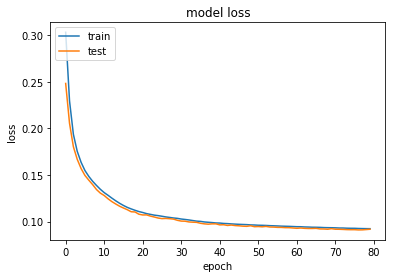

loss: 0.09245124639382883
val_loss: 0.09185030478522892


In [ ]:
if (use_serialized):
    history = load_from_file('multilayer_history.json')

else:
    multilayer_autoencoder.compile(optimizer=optimizer, loss=loss)
    start = time.time()
    history = multilayer_autoencoder.fit(train_images, train_images,
                            epochs=training_epochs,
                            batch_size=256,
                            shuffle=True,
                            validation_data=(test_images, test_images),
                            callbacks=callbacks).history
    print('training time:', time.time() - start)
    save_to_file(history, 'multilayer_history.json')
    multilayer_autoencoder.save('multilayer.h5')
    multilayer_encoder.save('multilayer_encoder.h5')
    multilayer_decoder.save('multilayer_decoder.h5')

plot_loss(history)
print("loss:", history["loss"][-1])
print("val_loss:", history["val_loss"][-1])

##  Тренировочная выборка

Что такое **loss и val_loss**?
При глубоком обучении **loss** - это величина, которую нейронная сеть пытается минимизировать: это расстояние между исходными данными и предсказаниями. Чтобы минимизировать это расстояние, нейронная сеть обучается, корректируя веса и смещения таким образом, чтобы уменьшить потери (loss).

**loss и val_loss** отличаются друг от друга тем, что первое применяется к набору обучающих данных, а второе - к тестовому набору. Таким образом, последнее является хорошим показателем того, как модель работает со скрытыми слоями данных.

Для предотвращения переобучения обращать внимание на **val_loss**

##  Тестовая выборка

In [ ]:
# encode images
encoded_images = multilayer_encoder.predict(test_images)
print("encoded images:", encoded_images.shape)

#decode images
decoded_images = multilayer_decoder.predict(encoded_images)
print("decoded images:", decoded_images.shape)

encoded images: (10500, 49)
decoded images: (10500, 784)


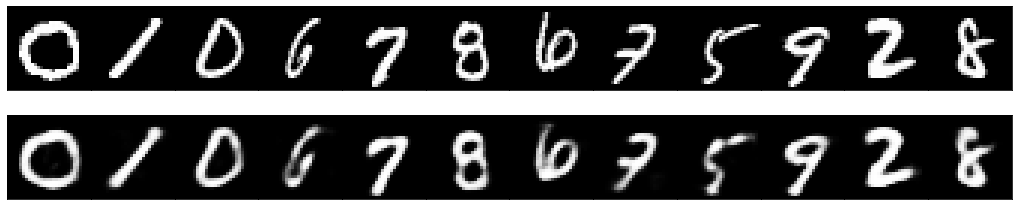

In [ ]:
plot_comparison(test_images, decoded_images)

# Сверточный автоэнкодер (CAE)

## Архитектура

![](https://i.imgur.com/veNO3TC.png)

In [ ]:
if (use_serialized):
    convolutional_autoencoder = load_model('convolutional.h5')
    convolutional_encoder = load_model('convolutional_encoder.h5')
    convolutional_decoder = load_model('convolutional_decoder.h5')

else:
    input_layer = Input(shape=(28, 28, 1))

    ## кодировщик
    # первая свертка (выходные данные 14x14)
    layer = Conv2D(16, (3, 3), activation=activation, padding='same')(input_layer)
    layer = MaxPooling2D((2, 2), padding='same')(layer)

    # вторая свертка (выводит 7x7)
    layer = Conv2D(16, (3, 3), activation=activation, padding='same')(layer)
    encoded_layer = MaxPooling2D((2, 2), padding='same')(layer)

    ##  декодер
    # первая деконволюция (выходные данные 14x14) - обратная операция свертке
    layer = Conv2D(16, (3, 3), activation=activation, padding='same')(encoded_layer)
    layer = UpSampling2D((2, 2))(layer)

    # вторая деконволюция (выходные данные 28x28)
    layer = Conv2D(16, (3, 3), activation=activation, padding='same')(layer)
    layer = UpSampling2D((2, 2))(layer)

    # дополнительный слой
    decoded_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

    # автоэнкодер
    convolutional_autoencoder = Model(input_layer, decoded_layer)
    convolutional_autoencoder._name = "convolutional_autoencoder"

    # отдельные модели кодировщика и декодера
    convolutional_encoder = Model(input_layer, encoded_layer)
    convolutional_encoder._name = "convolutional_encoder"

    encoded_input_layer = Input(shape=(7, 7, 16))
    convolutional_decoder = Model(encoded_input_layer,
        convolutional_autoencoder.layers[-1](
            convolutional_autoencoder.layers[-2](
                convolutional_autoencoder.layers[-3](
                    convolutional_autoencoder.layers[-4](
                        convolutional_autoencoder.layers[-5](
                            encoded_input_layer))))))

    convolutional_decoder._name = "convolutional_decoder"

# распечатать показатели моделей
convolutional_autoencoder.summary()
convolutional_encoder.summary()
convolutional_decoder.summary()


Model: "convolutional_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7,

## Обучение

Train on 59500 samples, validate on 10500 samples
Epoch 1/100
59500/59500 [==============================] - 5s 80us/step - loss: 0.1649 - val_loss: 0.1004
Epoch 2/100
59500/59500 [==============================] - 2s 31us/step - loss: 0.0937 - val_loss: 0.0872
Epoch 3/100
59500/59500 [==============================] - 2s 31us/step - loss: 0.0860 - val_loss: 0.0830
Epoch 4/100
59500/59500 [==============================] - 2s 31us/step - loss: 0.0823 - val_loss: 0.0804
Epoch 5/100
59500/59500 [==============================] - 2s 31us/step - loss: 0.0798 - val_loss: 0.0782
Epoch 6/100
59500/59500 [==============================] - 2s 31us/step - loss: 0.0781 - val_loss: 0.0760
Epoch 7/100
59500/59500 [==============================] - 2s 31us/step - loss: 0.0768 - val_loss: 0.0758
Epoch 8/100
59500/59500 [==============================] - 2s 31us/step - loss: 0.0759 - val_loss: 0.0748
Epoch 9/100
59500/59500 [==============================] - 2s 31us/step - loss: 0.0752 - val_loss: 0.0

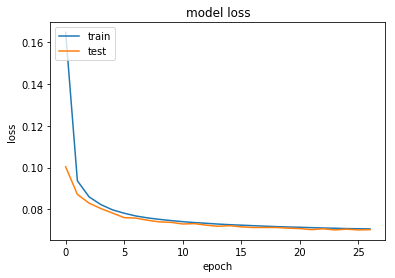

loss: 0.07061082866312075
val_loss: 0.07024533486933936


In [ ]:
if (use_serialized):
    history = load_from_file('convolutional_history.json')

else:
    convolutional_autoencoder.compile(optimizer=optimizer, loss=loss)

    reshaped_train_images = train_images.reshape((len(train_images), 28, 28, 1))
    reshaped_test_images = test_images.reshape((len(test_images), 28, 28, 1))

    start = time.time()
    history = convolutional_autoencoder.fit(reshaped_train_images, reshaped_train_images,
                            epochs=training_epochs,
                            batch_size=256,
                            shuffle=True,
                            validation_data=(reshaped_test_images, reshaped_test_images),
                            callbacks=callbacks).history
    print('training time:', time.time() - start)
    save_to_file(history, 'convolutional_history.json')
    convolutional_autoencoder.save('convolutional.h5')
    convolutional_encoder.save('convolutional_encoder.h5')
    convolutional_decoder.save('convolutional_decoder.h5')

plot_loss(history)
print("loss:", history["loss"][-1])
print("val_loss:", history["val_loss"][-1])

## Тестирование

In [ ]:
# encode images
encoded_images = convolutional_encoder.predict(reshaped_test_images)
print("encoded images:", encoded_images.shape)

#decode images
decoded_images = convolutional_decoder.predict(encoded_images)
print("decoded images:", decoded_images.shape)

encoded images: (10500, 7, 7, 16)
decoded images: (10500, 28, 28, 1)


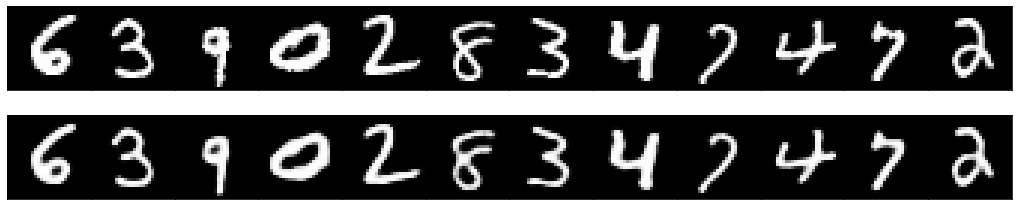

In [ ]:
plot_comparison(test_images, decoded_images)

# Разреженный автоэнкодер

## Архитектура

![](https://i.imgur.com/OrWEyXw.png)

In [ ]:
if (use_serialized):
    sparse_autoencoder = load_model('sparse.h5')
    sparse_encoder = load_model('sparse_encoder.h5')
    sparse_decoder = load_model('sparse_decoder.h5')

else:
    input_layer = Input(shape=(input_size,))

    # кодировщик
    encoded_layer = Dense(input_size, activation=activation,
        activity_regularizer=regularizers.l1(10e-7))(input_layer)

    # декодер
    decoded_layer = Dense(input_size, activation='sigmoid')(encoded_layer)

    # автоэнкодер
    sparse_autoencoder = Model(input_layer, decoded_layer)
    sparse_autoencoder._name = "sparse_autoencoder"

    # разделенные модели кодировщика и декодера
    sparse_encoder = Model(input_layer, encoded_layer)
    sparse_encoder._name = "sparse_encoder"

    encoded_input_layer = Input(shape=(input_size,))
    sparse_decoder = Model(encoded_input_layer,
       sparse_autoencoder.layers[-1](encoded_input_layer))
    sparse_decoder._name = "sparse_decoder"

# распечатать показатели моделей
sparse_autoencoder.summary()
sparse_encoder.summary()
sparse_decoder.summary()

## Обучение

Train on 59500 samples, validate on 10500 samples
Epoch 1/100
59500/59500 [==============================] - 1s 21us/step - loss: 0.3880 - val_loss: 0.3142
Epoch 2/100
59500/59500 [==============================] - 1s 19us/step - loss: 0.2948 - val_loss: 0.2749
Epoch 3/100
59500/59500 [==============================] - 1s 21us/step - loss: 0.2651 - val_loss: 0.2524
Epoch 4/100
59500/59500 [==============================] - 1s 19us/step - loss: 0.2467 - val_loss: 0.2373
Epoch 5/100
59500/59500 [==============================] - 1s 19us/step - loss: 0.2334 - val_loss: 0.2258
Epoch 6/100
59500/59500 [==============================] - 1s 19us/step - loss: 0.2230 - val_loss: 0.2164
Epoch 7/100
59500/59500 [==============================] - 1s 19us/step - loss: 0.2143 - val_loss: 0.2084
Epoch 8/100
59500/59500 [==============================] - 1s 19us/step - loss: 0.2068 - val_loss: 0.2015
Epoch 9/100
59500/59500 [==============================] - 1s 19us/step - loss: 0.2004 - val_loss: 0.1

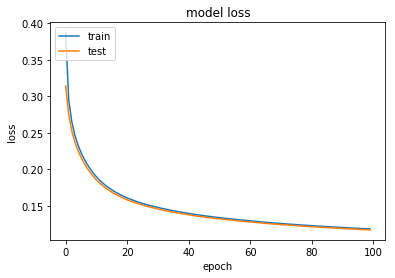

loss: 0.11815753888883511
val_loss: 0.11685318309636343


In [ ]:
if (use_serialized):
    history = load_from_file('sparse_history.json')

else:
    sparse_autoencoder.compile(optimizer=optimizer, loss=loss)
    start = time.time()
    history = sparse_autoencoder.fit(train_images, train_images,
                            epochs=training_epochs,
                            batch_size=256,
                            shuffle=True,
                            validation_data=(test_images, test_images),
                            callbacks=callbacks).history
    print('training time:', time.time() - start)
    save_to_file(history, 'sparse_history.json')
    sparse_autoencoder.save('sparse.h5')
    sparse_encoder.save('sparse_encoder.h5')
    sparse_decoder.save('sparse_decoder.h5')

plot_loss(history)
print("loss:", history["loss"][-1])
print("val_loss:", history["val_loss"][-1])


## Тестирование

In [ ]:
# encode images
encoded_images = sparse_encoder.predict(test_images)
print("encoded images:", encoded_images.shape)

#decode images
decoded_images = sparse_decoder.predict(encoded_images)
print("decoded images:", decoded_images.shape)

encoded images: (10500, 784)
decoded images: (10500, 784)


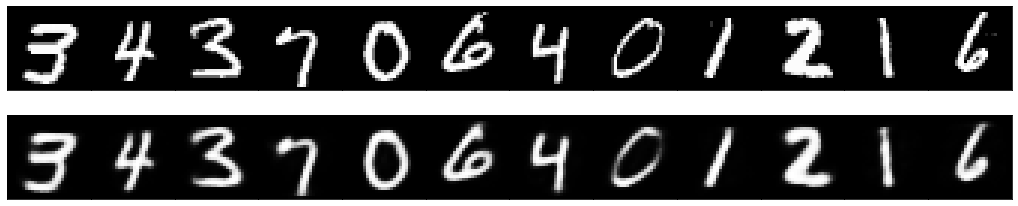

In [ ]:
plot_comparison(test_images, decoded_images)

# Шумоподавляющий автокодировщик

## Подготовка данных

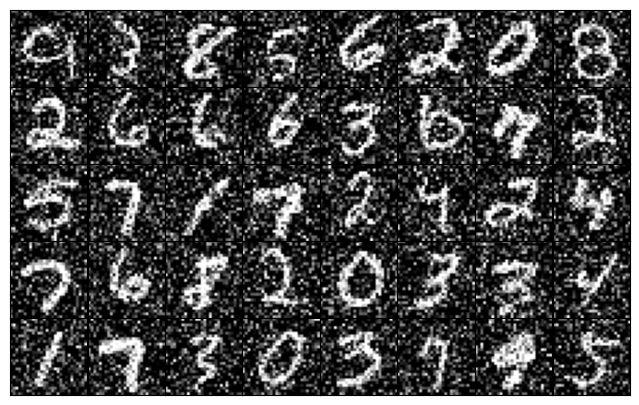

In [26]:
noise_factor = 0.4
noisy_train_images = np.clip(train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape), 0, 1)
noisy_test_images = np.clip(test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape), 0, 1)

plot_images_sample(noisy_train_images)

## Архитектура

![](https://i.imgur.com/byPzKk5.png)

In [28]:
if (use_serialized):
    denoising_autoencoder = load_model('denoising.h5')
    denoising_encoder = load_model('denoising_encoder.h5')
    denoising_decoder = load_model('denoising_decoder.h5')

else:
    input_layer = Input(shape=(28, 28, 1))

    ## encoder
    # first convolution (outputs 14x14)
    layer = Conv2D(32, (3, 3), activation=activation, padding='same')(input_layer)
    layer = MaxPooling2D((2, 2), padding='same')(layer)

    # second convolution (outputs 7x7)
    layer = Conv2D(32, (3, 3), activation=activation, padding='same')(layer)
    encoded_layer = MaxPooling2D((2, 2), padding='same')(layer)

    ## decoder
    # first deconvolution (outputs 14x14)
    layer = Conv2D(32, (3, 3), activation=activation, padding='same')(encoded_layer)
    layer = UpSampling2D((2, 2))(layer)

    # second deconvolution (outputs 28x28)
    layer = Conv2D(32, (3, 3), activation=activation, padding='same')(layer)
    layer = UpSampling2D((2, 2))(layer)

    decoded_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

    # autoencoder
    denoising_autoencoder = Model(input_layer, decoded_layer)
    denoising_autoencoder._name = "denoising_autoencoder"

    # separate encoder and decoder models
    denoising_encoder = Model(input_layer, encoded_layer)
    denoising_encoder._name = "denoising_encoder"

    encoded_input_layer = Input(shape=(7, 7, 32))
    denoising_decoder = Model(encoded_input_layer,
        denoising_autoencoder.layers[-1](
            denoising_autoencoder.layers[-2](
                denoising_autoencoder.layers[-3](
                    denoising_autoencoder.layers[-4](
                        denoising_autoencoder.layers[-5](
                            encoded_input_layer))))))

    denoising_decoder._name = "denoising_decoder"

# print model summaries
denoising_autoencoder.summary()
denoising_encoder.summary()
denoising_decoder.summary()

Model: "denoising_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)

## Training

Train on 59500 samples, validate on 10500 samples
Epoch 1/100
59500/59500 [==============================] - 3s 46us/step - loss: 0.1889 - val_loss: 0.1259
Epoch 2/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.1179 - val_loss: 0.1120
Epoch 3/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.1088 - val_loss: 0.1051
Epoch 4/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.1043 - val_loss: 0.1023
Epoch 5/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.1013 - val_loss: 0.0976
Epoch 6/100
59500/59500 [==============================] - 2s 37us/step - loss: 0.0992 - val_loss: 0.0965
Epoch 7/100
59500/59500 [==============================] - 2s 37us/step - loss: 0.0976 - val_loss: 0.0958
Epoch 8/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.0962 - val_loss: 0.0947
Epoch 9/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.0951 - val_loss: 0.0

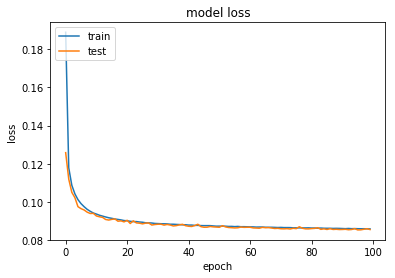

loss: 0.08596433567099211
val_loss: 0.08561013269992102


In [ ]:
if (use_serialized):
    history = load_from_file('denoising_history.json')

else:
    denoising_autoencoder.compile(optimizer=optimizer, loss=loss)

    reshaped_noisy_train_images = noisy_train_images.reshape((len(noisy_train_images), 28, 28, 1))
    reshaped_train_images = train_images.reshape((len(train_images), 28, 28, 1))
    reshaped_test_images = test_images.reshape((len(test_images), 28, 28, 1))
    reshaped_noisy_test_images = noisy_test_images.reshape((len(noisy_test_images), 28, 28, 1))

    start = time.time()
    history = denoising_autoencoder.fit(reshaped_noisy_train_images, reshaped_train_images,
                            epochs=training_epochs,
                            batch_size=256,
                            shuffle=True,
                            validation_data=(reshaped_noisy_test_images, reshaped_test_images)).history
    print('training time:', time.time() - start)
    save_to_file(history, 'denoising_history.json')
    denoising_autoencoder.save('denoising.h5')
    denoising_encoder.save('denoising_encoder.h5')
    denoising_decoder.save('denoising_decoder.h5')

plot_loss(history)
print("loss:", history["loss"][-1])
print("val_loss:", history["val_loss"][-1])

## Testing

Train on 59500 samples, validate on 10500 samples
Epoch 1/100
59500/59500 [==============================] - 3s 46us/step - loss: 0.1889 - val_loss: 0.1259
Epoch 2/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.1179 - val_loss: 0.1120
Epoch 3/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.1088 - val_loss: 0.1051
Epoch 4/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.1043 - val_loss: 0.1023
Epoch 5/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.1013 - val_loss: 0.0976
Epoch 6/100
59500/59500 [==============================] - 2s 37us/step - loss: 0.0992 - val_loss: 0.0965
Epoch 7/100
59500/59500 [==============================] - 2s 37us/step - loss: 0.0976 - val_loss: 0.0958
Epoch 8/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.0962 - val_loss: 0.0947
Epoch 9/100
59500/59500 [==============================] - 2s 38us/step - loss: 0.0951 - val_loss: 0.0

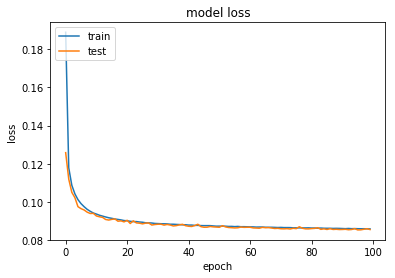

loss: 0.08596433567099211
val_loss: 0.08561013269992102


In [ ]:
if (use_serialized):
    history = load_from_file('denoising_history.json')

else:
    denoising_autoencoder.compile(optimizer=optimizer, loss=loss)

    reshaped_noisy_train_images = noisy_train_images.reshape((len(noisy_train_images), 28, 28, 1))
    reshaped_train_images = train_images.reshape((len(train_images), 28, 28, 1))
    reshaped_test_images = test_images.reshape((len(test_images), 28, 28, 1))
    reshaped_noisy_test_images = noisy_test_images.reshape((len(noisy_test_images), 28, 28, 1))

    start = time.time()
    history = denoising_autoencoder.fit(reshaped_noisy_train_images, reshaped_train_images,
                            epochs=training_epochs,
                            batch_size=256,
                            shuffle=True,
                            validation_data=(reshaped_noisy_test_images, reshaped_test_images)).history
    print('training time:', time.time() - start)
    save_to_file(history, 'denoising_history.json')
    denoising_autoencoder.save('denoising.h5')
    denoising_encoder.save('denoising_encoder.h5')
    denoising_decoder.save('denoising_decoder.h5')

plot_loss(history)
print("loss:", history["loss"][-1])
print("val_loss:", history["val_loss"][-1])

In [ ]:
# encode images
encoded_images = denoising_encoder.predict(reshaped_noisy_test_images)
print("encoded images:", encoded_images.shape)

#decode images
decoded_images = denoising_decoder.predict(encoded_images)
print("decoded images:", decoded_images.shape)

encoded images: (10500, 7, 7, 32)
decoded images: (10500, 28, 28, 1)


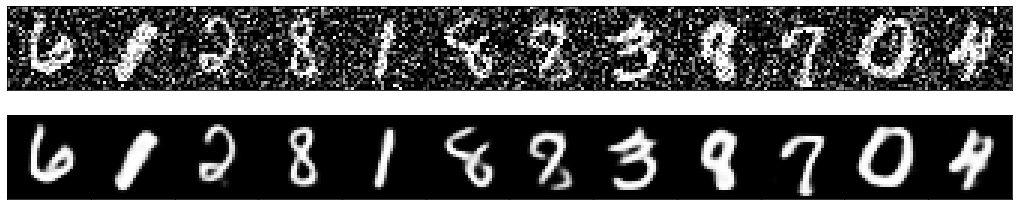

In [ ]:
plot_comparison(noisy_test_images, decoded_images)